# Constrained Embedding

My recent work has explored deep generative models where the goal is to design a compound that is highly similar (in a 3D sense) to either the molecule you started with or two fragments.

We have assessed 3D similarity by generating conformers of the generated molecules, and comparing them to a conformation of the original molecule/fragments via several metrics. This approach has both the advantage AND the disadvantage of the generated conformers being independent of the target conformer.

I recently learnt about the RDKit function `AllChem.ConstrainedEmbed()`, which generates conformations where the positions of a set of atoms are constrained to match the coordinates of a template molecule.

Greg has two blog posts about the function ([here](http://rdkit.blogspot.com/2013/12/using-allchemconstrainedembed.html) and [here](http://rdkit.blogspot.com/2019/01/more-on-constrained-embedding.html)) but I wanted to explore this in a little more detail and assess how realistic these conformers were and if it could be useful in assessing 3D similarity.

### Requirements

The majority of this notebook uses rdkit and numpy only. At the end we will use py3Dmol to visualise some of the conformers. If you want to install this then skip this part/just look at our pretty pictures.

In [1]:
import numpy as np

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, rdMolAlign
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
print(rdBase.rdkitVersion)

from utils import *

2018.09.1


We're going to work with an example of fragment linking<sup>1</sup>, extracted from the PDB. To keep it simple, we'll use only the PBD structure of the linked fragments [PDB ID 3IVX](https://www.rcsb.org/structure/3IVX) and assume the binding mode of the fragments is identical.

[1. Hung et al., Application of Fragment Growing and Fragment Linking to the Discovery of Inhibitors of Mycobacterium tuberculosis Pantothenate Synthetase. Angew. Chem., Int. Ed. 2009, 48, 8452–8456.](https://onlinelibrary.wiley.com/doi/full/10.1002/anie.200903821)

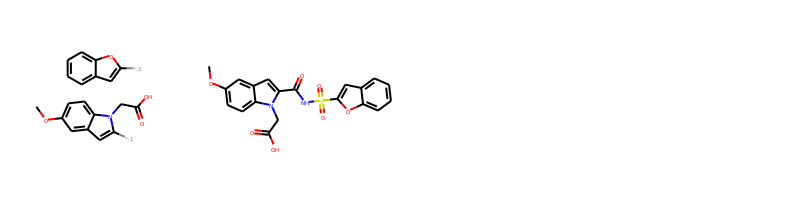

In [3]:
hung_frags = "COc1ccc2c(c1)cc([*:1])n2CC(=O)O.c1ccc2oc([*:2])cc2c1"
hung_3IVX = [x for x in Chem.SDMolSupplier("./3IVX_pdb_ligands.sdf")][0]
hung_3IVX_2d = Chem.Mol(hung_3IVX)
_ = AllChem.Compute2DCoords(hung_3IVX_2d)

hung_3IVX_noinfo = Chem.MolToSmiles(hung_3IVX)

to_display = [Chem.MolFromSmiles(hung_frags), hung_3IVX_2d]

Draw.MolsToGridImage(to_display,molsPerRow=4)

Now let's get the 3D coordinates of the fragments, as these are what we want to compare our conformers of the full molecule to and the atoms we will use for our constrained embedding. We'll use a custom function `get_frags`, that accounts for multiple possible matches of the starting fragments.

Once we've done this, let's check the alignment.

In [4]:
du = Chem.MolFromSmiles('*')
clean_frag = Chem.RemoveHs(AllChem.ReplaceSubstructs(Chem.MolFromSmiles(hung_frags),du,Chem.MolFromSmiles('[H]'),True)[0])
frags_3d = get_frags(hung_3IVX, clean_frag)

RDKit WARNING: [16:31:21] WARNING: not removing hydrogen atom without neighbors


In [5]:
rms = AllChem.AlignMol(frags_3d,hung_3IVX)
print("RMS: %.3f" % rms)
Chem.SanitizeMol(frags_3d)
Chem.SanitizeMol(hung_3IVX)

RMS: 0.000


rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

### Unconstrained conformer generation

Let's see how good conformer generation is when we impose no additional constraints on the embedding.

The molecule has seven rotatable bonds, so 50 conformers should be enough to sample the conformational space effectively<sup>1</sup>.

In these examples, we use RDKit's default embedding algorithm and UFF as our force field.
    
[1. Ebejer et al., Freely Available Conformer Generation Methods: How Good Are They? J. Chem. Inf. Model. 2012, 52, 1146–1158.](https://pubs.acs.org/doi/abs/10.1021/ci2004658)

In [6]:
num_confs = 50 # How many conformers should each method generate.

In [7]:
rms_full_list = []
rms_frags_list = []
cenergy_list = []

np.random.seed(seed=42)
for seed in [int(x) for x in np.random.randint(1,100001, num_confs)]:
    # Generate conformer
    nm = Chem.MolFromSmiles(hung_3IVX_noinfo)
    nm = Chem.AddHs(nm)
    AllChem.EmbedMolecule(nm,randomSeed=seed)
    AllChem.UFFOptimizeMolecule(nm)
    cenergy = AllChem.UFFGetMoleculeForceField(nm).CalcEnergy()
    nm = Chem.RemoveHs(nm)
    
    # Analyse conformer
    rms_full = AllChem.AlignMol(nm, hung_3IVX) # Consider using AllChem.GetBestRMS(nm, hung_3IVX)
    match = nm.GetSubstructMatch(frags_3d)
    if not match:
        raise ValueError("molecule doesn't match the core")
    algMap = [(j, i) for i, j in enumerate(match)]
    rms_frags = AllChem.AlignMol(nm, frags_3d, atomMap=algMap)
    
    rms_full_list.append(rms_full)
    rms_frags_list.append(rms_frags)
    cenergy_list.append(cenergy)
    
    # Record best
    if rms_full == min(rms_full_list):
        best_unconstrained = Chem.Mol(nm)
        best_unconstrained.SetProp("Energy", "%.1f" % cenergy)
    
print("RMS Full Mol\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_full_list), min(rms_full_list), max(rms_full_list)))
print("RMS Fragments\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_frags_list), min(rms_frags_list), max(rms_frags_list)))
print("Energy\t\t- Mean: %.1f,\tMin: %.1f,\tMax: %.1f" % (np.mean(cenergy_list), min(cenergy_list), max(cenergy_list)))

RMS Full Mol	- Mean: 1.98,	Min: 1.07,	Max: 3.00
RMS Fragments	- Mean: 1.73,	Min: 0.89,	Max: 2.64
Energy		- Mean: 119.2,	Min: 117.9,	Max: 123.2


A best RMSD of 1.07 Angstroms suggests some ability to sample conformers, but is still a fair way from optimal.

### Constrained Embedding

Will a constrained embedding help us? Let's use the coordinates of the fragments to constrain the embedding of the molecule. 

In [8]:
rms_full_list = []
rms_frags_list = []
cenergy_list = []

np.random.seed(seed=42)
for seed in [int(x) for x in np.random.randint(1,100001, num_confs)]:
    # Generate conformer
    nm = Chem.MolFromSmiles(hung_3IVX_noinfo)
    nm = Chem.AddHs(nm)
    AllChem.ConstrainedEmbed(nm,frags_3d,randomseed=seed)
    cenergy = AllChem.UFFGetMoleculeForceField(nm).CalcEnergy()
    nm = Chem.RemoveHs(nm)
    
    # Analyse conformer
    rms_full = AllChem.AlignMol(nm, hung_3IVX)
    match = nm.GetSubstructMatch(frags_3d)
    if not match:
        raise ValueError("molecule doesn't match the core")
    algMap = [(j, i) for i, j in enumerate(match)]
    rms_frags = AllChem.AlignMol(nm, frags_3d, atomMap=algMap) # Note we could access this directly with rms_frags = float(nm.GetProp('EmbedRMS'))
    
    rms_full_list.append(rms_full)
    rms_frags_list.append(rms_frags)
    cenergy_list.append(cenergy)
    
    # Record best
    if rms_full == min(rms_full_list):
        best_constrained = Chem.Mol(nm)
        best_constrained.SetProp("Energy", "%.1f" % cenergy)
    
print("RMS Full Mol\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_full_list), min(rms_full_list), max(rms_full_list)))
print("RMS Fragments\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_frags_list), min(rms_frags_list), max(rms_frags_list)))
print("Energy\t\t- Mean: %.1f,\tMin: %.1f,\tMax: %.1f" % (np.mean(cenergy_list), min(cenergy_list), max(cenergy_list)))

RMS Full Mol	- Mean: 0.60,	Min: 0.17,	Max: 0.84
RMS Fragments	- Mean: 0.09,	Min: 0.08,	Max: 0.09
Energy		- Mean: 139.8,	Min: 133.6,	Max: 147.1


These conformers are MUCH better, with the worst conformer more similar than the best unconstrained conformer, and the conformations of the fragments being almost identical to the reference molecule as a result of the additional constraints.

However, note that the average energy has increased, suggesting some conformational strain. We would ideally like the conformers generated to be no more strained than in the unconstrained case, so let's try adding an additional minimisation step after performing the constrained embedding.

In [9]:
rms_full_list = []
rms_frags_list = []
cenergy_list = []

np.random.seed(seed=42)
for seed in [int(x) for x in np.random.randint(1,100001, num_confs)]:
    # Generate conformer
    nm = Chem.MolFromSmiles(hung_3IVX_noinfo)
    nm = Chem.AddHs(nm)
    AllChem.ConstrainedEmbed(nm,frags_3d,randomseed=seed)
    AllChem.UFFOptimizeMolecule(nm)
    cenergy = AllChem.UFFGetMoleculeForceField(nm).CalcEnergy()
    nm = Chem.RemoveHs(nm)
    
    # Analyse conformer
    rms_full = AllChem.AlignMol(nm, hung_3IVX)
    match = nm.GetSubstructMatch(frags_3d)
    if not match:
        raise ValueError("molecule doesn't match the core")
    algMap = [(j, i) for i, j in enumerate(match)]
    rms_frags = AllChem.AlignMol(nm, frags_3d, atomMap=algMap)
    
    rms_full_list.append(rms_full)
    rms_frags_list.append(rms_frags)
    cenergy_list.append(cenergy)
    
    # Record best
    if rms_full == min(rms_full_list):
        best_constrainedopt = Chem.Mol(nm)
        best_constrainedopt.SetProp("Energy", "%.1f" % cenergy)
    
print("RMS Full Mol\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_full_list), min(rms_full_list), max(rms_full_list)))
print("RMS Fragments\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_frags_list), min(rms_frags_list), max(rms_frags_list)))
print("Energy\t\t- Mean: %.1f,\tMin: %.1f,\tMax: %.1f" % (np.mean(cenergy_list), min(cenergy_list), max(cenergy_list)))

RMS Full Mol	- Mean: 1.15,	Min: 0.88,	Max: 1.89
RMS Fragments	- Mean: 0.89,	Min: 0.72,	Max: 1.63
Energy		- Mean: 119.2,	Min: 118.2,	Max: 123.7


The RMSDs have naturally gotten worse, in particular the fragments, but the average RMSD is almost 1 Angstom lower than in the unconstrained case and crucially the average energy of the conformations now match the uncontrained generation.

This suggests this is a valid way to bias the search of conformational space to the space that we're interested in, but if we add an additional minimisation step, will not produce strained conformers.

### Visualising

If you have [py3dmol](https://pypi.org/project/py3Dmol/), let's take a look at the conformers themselves.

In [10]:
import py3Dmol

In [11]:
def drawit(ms, p=None, confId=-1):
        if p is None:
            p = py3Dmol.view(width=400, height=300)
        p.removeAllModels()
        for m in ms:
            mb = Chem.MolToMolBlock(m, confId=confId)
            p.addModel(mb, 'sdf')
        p.setStyle({'stick':{}})
        p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
        return p.show()

This is the active conformation extracted from the PDB, together with the energy of the conformer under the UFF force field.

In [12]:
print("Energy: %.1f" % AllChem.UFFGetMoleculeForceField(hung_3IVX).CalcEnergy())
drawit([hung_3IVX])

Energy: 206.9


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Let's look at the best conformer through the unconstrained conformer generation.

In [13]:
print("RMS frags: %.3f, Energy: %s" % (AllChem.AlignMol(frags_3d, best_unconstrained), best_unconstrained.GetProp("Energy")))
drawit((hung_3IVX, best_unconstrained))

RMS frags: 1.074, Energy: 118.3


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
print("RMS frags: %.3f, Energy: %s" % (AllChem.AlignMol(frags_3d, best_constrained), best_constrained.GetProp("Energy")))
drawit((hung_3IVX, best_constrained))

RMS frags: 0.093, Energy: 133.6


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
print("RMS frags: %.3f, Energy: %s" % (AllChem.AlignMol(frags_3d, best_constrainedopt), best_constrainedopt.GetProp("Energy")))
drawit((hung_3IVX, best_constrainedopt))

RMS frags: 0.724, Energy: 118.7


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# An alternate option?

One of the issues with the constrained embedding was forcing atoms to match precisely the positions of the core atoms. 

If we relax this procedure slightly, will we produce lower energy conformers, that more closely match the active conformation than either of the two procedures above? 

To do this, we modify the function `ConstainedEmbed` to taken an additional argument `tdist`, that determines the maximum distance of the atoms to the positions of the core atoms i.e. the amount of slack we permit in the system.
The implementation for this function, `ConstrainedEmbed_Slack`, can be found in utils.py.

We're not sure exactly what value of `tdist` to use, so let's perform a quick search over posible values to see how it varies. Note `tdist=0` corresponds to the original `ConstrainedEmbed` function.

In [16]:
for dist in [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]:
    print("DIST: ", dist)

    rms_full_list = []
    rms_frags_list = []
    cenergy_list = []

    np.random.seed(seed=42)
    for seed in [int(x) for x in np.random.randint(1,100001, 50)]:
        # Generate conformer
        nm = Chem.MolFromSmiles(hung_3IVX_noinfo)
        nm = Chem.AddHs(nm)
        ConstrainedEmbed_Slack(nm,frags_3d,randomseed=seed,tdist=dist)
        cenergy = AllChem.UFFGetMoleculeForceField(nm).CalcEnergy()
        nm = Chem.RemoveHs(nm)
        
        # Analyse conformer
        rms_full = AllChem.AlignMol(nm, hung_3IVX)
        match = nm.GetSubstructMatch(frags_3d)
        if not match:
            raise ValueError("molecule doesn't match the core")
        algMap = [(j, i) for i, j in enumerate(match)]
        rms_frags = AllChem.AlignMol(nm, frags_3d, atomMap=algMap) # Note we could access this directly with rms_frags = float(nm.GetProp('EmbedRMS'))

        rms_full_list.append(rms_full)
        rms_frags_list.append(rms_frags)
        cenergy_list.append(cenergy)
        
        # Record best for dist ==0.75
        if dist == 0.75:
            if rms_full == min(rms_full_list):
                best_constrained_flex = Chem.Mol(nm)
                best_constrained_flex.SetProp("Energy", "%.1f" % cenergy)

    print("RMS Full Mol\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_full_list), min(rms_full_list), max(rms_full_list)))
    print("RMS Fragments\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_frags_list), min(rms_frags_list), max(rms_frags_list)))
    print("Energy\t\t- Mean: %.1f,\tMin: %.1f,\tMax: %.1f" % (np.mean(cenergy_list), min(cenergy_list), max(cenergy_list)))
    print()

DIST:  0.0
RMS Full Mol	- Mean: 0.62,	Min: 0.17,	Max: 0.89
RMS Fragments	- Mean: 0.09,	Min: 0.08,	Max: 0.09
Energy		- Mean: 140.6,	Min: 133.6,	Max: 147.1

DIST:  0.1
RMS Full Mol	- Mean: 0.60,	Min: 0.18,	Max: 0.83
RMS Fragments	- Mean: 0.14,	Min: 0.12,	Max: 0.14
Energy		- Mean: 132.8,	Min: 126.3,	Max: 138.2

DIST:  0.25
RMS Full Mol	- Mean: 0.59,	Min: 0.22,	Max: 0.94
RMS Fragments	- Mean: 0.22,	Min: 0.21,	Max: 0.23
Energy		- Mean: 126.9,	Min: 122.1,	Max: 133.3

DIST:  0.5
RMS Full Mol	- Mean: 0.70,	Min: 0.37,	Max: 1.14
RMS Fragments	- Mean: 0.36,	Min: 0.35,	Max: 0.40
Energy		- Mean: 123.2,	Min: 119.9,	Max: 142.3

DIST:  0.75
RMS Full Mol	- Mean: 0.86,	Min: 0.54,	Max: 1.39
RMS Fragments	- Mean: 0.51,	Min: 0.48,	Max: 0.59
Energy		- Mean: 122.0,	Min: 119.1,	Max: 154.4

DIST:  1.0
RMS Full Mol	- Mean: 0.91,	Min: 0.57,	Max: 1.30
RMS Fragments	- Mean: 0.62,	Min: 0.51,	Max: 0.68
Energy		- Mean: 121.8,	Min: 118.6,	Max: 127.3



As we increase the value of `tdist` the RMSDs increase, but the energies increase, exhibiting the desired behaviour.

For all values of `tdist` of at least 0.5, the energies of the conformers is in line with the unconstrained conformer generation, or the constained conformer generation that was followed by a subsequent unconstained optimisation step.

However, the RMSDs are substantiall lower than both options. Let's visualise the best conformer with `tdist==0.75`

In [17]:
print("RMS: %.3f, Energy: %s" % (AllChem.AlignMol(best_constrained_flex, hung_3IVX), best_constrained_flex.GetProp("Energy")))
drawit((hung_3IVX, best_constrained_flex))

RMS: 0.537, Energy: 120.0


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Conclusions

We have seen how to use the RDKit function `ConstrainedEmbed` and examined the energies of the conformation produced. In addition, we have explored two distinct strategies for ensuring the conformers are not strained (according to your favourite force field).

Unforunately, using `ConstrainedEmbed` with two distinct fragments, rather than a single connected subcomponent, is relatively brittle and results in conformers not able to be generated.

In a future notebook, I will describe a method that is more robust to changes in the core of a molecule but still allows good 3D alignment at energies similar to unconstrained conformer generation.